In [25]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import skimage
import skimage.color
import skimage.feature
import skimage.transform
import skimage.io

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
class convertrgb2gray(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,x,y=None):
        return self
    def transform(self,x,y=None):
        return np.array([skimage.color.rgb2gray(img) for img in x])
    

class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=11,pixels_per_cell=(10,10),cells_per_block=(2,2)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
    def fit(self,x,y=None):
        return self
    
    def transform(self,x,y=None):
        def temp_hog(img):
            hog_features = skimage.feature.hog(img,orientations=self.orientations,
                                pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block)
            return hog_features
        return np.array([temp_hog(img) for img in x])

Prepare Pipeline for Prediction

In [26]:
model = pickle.load(open('Image_Classification_SGD.pkl','rb'))
scalar = pickle.load(open('Scalar.pkl','rb'))

In [34]:
#1) Read Image
image = skimage.io.imread('eagle1.jpg')
#2) Rescale Image into 80x80
resize_image = skimage.transform.resize(image,(80,80))
rescale_image = 255*resize_image
transform_image = rescale_image.astype(np.uint8)
#3)Both Classes - RGB2Gray and HOG
gray = skimage.color.rgb2gray(transform_image)
feature_vector = skimage.feature.hog(gray,orientations=11,pixels_per_cell=(10,10),cells_per_block=(2,2))
#now transform feature vector
scaled = scalar.transform(feature_vector.reshape(1,-1))
#4)Pass to model
result = model.predict(scaled)

result

array(['eagle'], dtype='<U8')

In [37]:
#get confidence intervals of all classes
dec_val = model.decision_function(scaled)
dec_val = dec_val.flatten()

In [38]:
labels = model.classes_

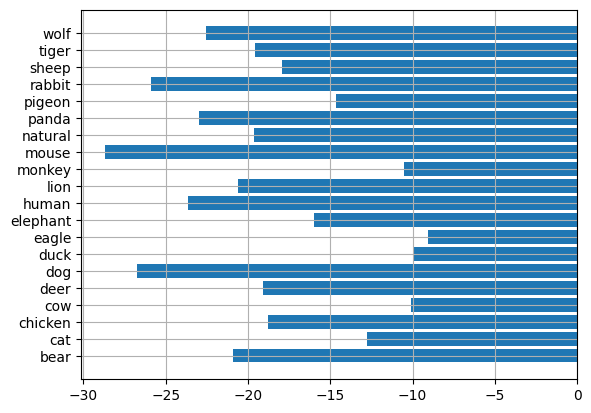

In [39]:
plt.barh(labels,dec_val)
plt.grid()

In [40]:
#cal z score
z = scipy.stats.zscore(dec_val)
probs = scipy.special.softmax(z)
probs

array([0.02037141, 0.08465789, 0.02959438, 0.13504775, 0.02805584,
       0.00729907, 0.13702085, 0.16186193, 0.04800253, 0.0125725 ,
       0.02148313, 0.12499726, 0.00519946, 0.02545975, 0.01408971,
       0.06057838, 0.00848159, 0.03414219, 0.02580558, 0.01527878])

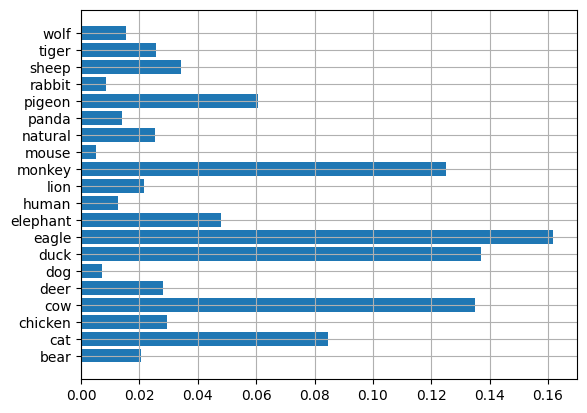

In [41]:
plt.barh(labels,probs)
plt.grid()

In [42]:
#lets get top 5 probabilities
top_5_ind = probs.argsort()[::-1][:5]
top_5_ind

array([ 7,  6,  3, 11,  1], dtype=int64)

In [43]:
top_5_labs = labels[top_5_ind]
top_5_labs

array(['eagle', 'duck', 'cow', 'monkey', 'cat'], dtype='<U8')

In [45]:
top_5_probs = probs[top_5_ind]
top_5_probs

array([0.16186193, 0.13702085, 0.13504775, 0.12499726, 0.08465789])

In [49]:
best_dict = dict()
for key,val in zip(top_5_labs,top_5_probs):
    best_dict.update({key:np.round(val,3)})
best_dict

{'eagle': 0.162, 'duck': 0.137, 'cow': 0.135, 'monkey': 0.125, 'cat': 0.085}

In [50]:
#lets integrate everything into a single function
def pipe_model(path,scalar,model_sgd):
    #1) Read Image
    image = skimage.io.imread(path)
    #2) Rescale Image into 80x80
    resize_image = skimage.transform.resize(image,(80,80))
    rescale_image = 255*resize_image
    transform_image = rescale_image.astype(np.uint8)
    #3)Both Classes - RGB2Gray and HOG
    gray = skimage.color.rgb2gray(transform_image)
    feature_vector = skimage.feature.hog(gray,orientations=11,pixels_per_cell=(10,10),cells_per_block=(2,2))
    #now transform feature vector
    scaled = scalar.transform(feature_vector.reshape(1,-1))
    #4)Pass to model
    result = model_sgd.predict(scaled)
    #get confidence intervals of all classes
    dec_val = model.decision_function(scaled).flatten()
    labels = model_sgd.classes_
    #cal z score
    probs = scipy.special.softmax(scipy.stats.zscore(dec_val))
    #lets get top 5 probabilities
    top_5_ind = probs.argsort()[::-1][:5]
    top_5_labs = labels[top_5_ind]
    top_5_probs = probs[top_5_ind]
    best_dict = dict()
    for key,val in zip(top_5_labs,top_5_probs):
        best_dict.update({key:np.round(val,3)})
    return best_dict

In [52]:
pipe_model('eagle1.jpg',scalar,model)

{'eagle': 0.162, 'duck': 0.137, 'cow': 0.135, 'monkey': 0.125, 'cat': 0.085}